In [1]:
import gymnasium as gym
import numpy as np
import math
import matplotlib.pyplot as plt 
import matplotlib.colors as colors
import stable_baselines3
import pandas as pd
import time
from utils import set_size
from utils import linestyle_tuple
from utils import load_csv
from stable_baselines3 import PPO
from stable_baselines3 import SAC
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.callbacks import CheckpointCallback

from pde_control_gym.src.environments1d.brain_tumor_env import TherapyWrapper

In [2]:
import os
import sys
from contextlib import contextmanager

@contextmanager
def suppress_output():
    """Suppress all print statements within context."""
    with open(os.devnull, 'w') as devnull:
        old_stdout = sys.stdout
        old_stderr = sys.stderr
        sys.stdout = devnull
        sys.stderr = devnull
        try:
            yield
        finally:
            sys.stdout = old_stdout
            sys.stderr = old_stderr


In [3]:
# Print Versioning
print("Gym version", gym.__version__)
print("Numpy version", np.__version__)
print("Stable Baselines3 version", stable_baselines3.__version__)

Gym version 1.1.1
Numpy version 2.2.5
Stable Baselines3 version 2.6.0


In [4]:
# Set initial condition function here
def getInitialCondition(X, nx):
    xScale = np.linspace(0, X, nx)
    c0 = 0.8 * 1e5 * np.exp(-0.25 * (xScale ** 2))
    return c0

In [ ]:
# Timestep and spatial step for PDE Solver

T = 600
X = 200
dt = 1
dx = 1

In [6]:
from pde_control_gym.src import BrainTumorReward
reward_class = BrainTumorReward()

Parameters = {
  "T": T,
  "X": X,
  "dt": dt,
  "dx": dx,
  "reward_class": reward_class,
  "normalize": True,
  "D": 0.2,
  "rho": 0.03,
  "alpha": 0.04,
  "alpha_beta_ratio": 10,
  "k": 1e5,
  "t1_detection_radius": 15,
  "t1_death_radius": 35,
  "reset_init_condition_func": getInitialCondition,

  "total_dosage": 61.2 # what the action controls the use of
}


In [ ]:
# Create train environment

trainParameters = Parameters.copy()
trainParameters["verbose"] = False
env_train_base = gym.make("PDEControlGym-BrainTumor1D", **trainParameters)
env_train_wrapped = TherapyWrapper(env_train_base, weekends=False, verbose=False)
with suppress_output():
    env_train_wrapped.benchmark()

In [ ]:
# Save a checkpoint every 10k steps

checkpoint_callback = CheckpointCallback(
  save_freq=10000,
  save_path="./logsPPO",
  name_prefix="rl_model",
  save_replay_buffer=True,
  save_vecnormalize=True,
)

# TRAINING. SKIP IF WANT TO USE PRELOADED MODELS
# model = PPO("MlpPolicy", env_train_wrapped, verbose=1, tensorboard_log="./tb/")
# model.learn(total_timesteps=1e6, callback=checkpoint_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./tb/PPO_6
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 5.32     |
|    ep_rew_mean     | -3.72    |
| time/              |          |
|    fps             | 329      |
|    iterations      | 1        |
|    time_elapsed    | 6        |
|    total_timesteps | 2048     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 5.02         |
|    ep_rew_mean          | -3.07        |
| time/                   |              |
|    fps                  | 317          |
|    iterations           | 2            |
|    time_elapsed         | 12           |
|    total_timesteps      | 4096         |
| train/                  |              |
|    approx_kl            | 0.0073720333 |
|    clip_fraction        | 0.0416       |
|    clip_range           | 

Text(0, 0.5, 'Average Reward')

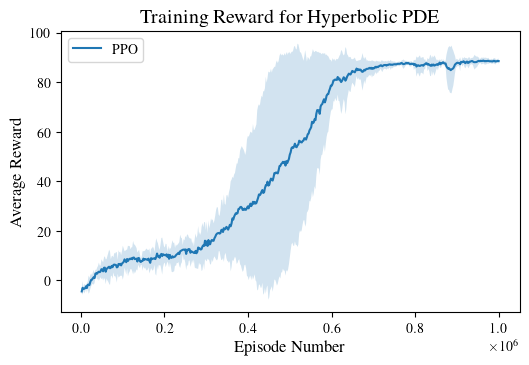

In [ ]:
# Visualize Rewards

# TensorBoard reward plot csv paths
filenamesPPO = ["PPOData/PPO_1.csv", "PPOData/PPO_2.csv", "PPOData/PPO_3.csv", "PPOData/PPO_6.csv"]

timePPOArr = []
rewardPPOArr = []
for name in filenamesPPO:
    times, rewards = load_csv(name)
    timePPOArr.append(times)
    rewardPPOArr.append(rewards)

# takes max amount of timesteps all data has
maxTimestep = np.inf
for data in timePPOArr:
    maxTimestep = min(maxTimestep, data[-1])

# remove data after minTimestep
maxDataSeqPPO = []
for data in timePPOArr:
    for i in range(len(data)):
        if data[i] >= maxTimestep:
            maxDataSeqPPO.append(i)
            break
        
# Get mean and std of each value at time step 
rewardArrCleanPPO = []
for i, data in enumerate(rewardPPOArr):
    rewardArrCleanPPO.append(data[:min(maxDataSeqPPO)])
rewardArrPPO = np.array(rewardArrCleanPPO)
meanArrPPO = rewardArrPPO.mean(axis=0)
stdArrPPO = rewardArrPPO.std(axis=0)

# Set size according to latex textwidth
fig = plt.figure(figsize=set_size(432, 0.99, (1, 1), height_add=0))
ax = fig.subplots(ncols=1)
t = timePPOArr[0]
x = t[:maxDataSeqPPO[0]]
mean = meanArrPPO
std = stdArrPPO
# 95 confidence interval
cis = (mean - 2*std, mean + 2*std)
ax.plot(x, mean, label="PPO")
ax.fill_between(x, cis[0], cis[1], alpha=0.2)

plt.legend()
plt.title("Training Reward for Hyperbolic PDE")
plt.xlabel("Episode Number")
plt.ylabel("Average Reward")

In [ ]:
# Runs a single episode calculation
# Model takes a controller
# Parameter is the PPO model
def runSingleEpisode(model, env, parameter):
    terminate = False
    truncate = False

    # Holds the resulting states
    uStorage = []
    rew = 0

    # Reset Environment
    obs,__ = env.reset()
    uStorage.append(obs)

    while not truncate and not terminate:
        action = model(obs, parameter)
        obs, rewards, terminate, truncate, info = env.step(action)
        uStorage.append(obs)
        rew += rewards 

    u = np.array(uStorage)
    return rew, u

In [ ]:
# Define controllers
def openLoopController(_, _a):
    return 0

# Hardcoded for 34 consecutive treatment days using 1.8Gy each = 61.2Gy
paper_proportions = [1/34] * 34

def paperProportionGenerator(proportions):
    for p in proportions:
        yield p
    while True:
        yield 0

def makePaperController(proportions):
    paper_generator = paperProportionGenerator(proportions)

    def controller(_, __):
        return next(paper_generator)

    return controller

def RLController(obs, model):
    action, _state = model.predict(obs)
    return action

In [ ]:
# Run and log episode with open loop
env_ol_base = gym.make("PDEControlGym-BrainTumor1D", **Parameters)
env_ol_wrapped = TherapyWrapper(env_ol_base, weekends=False, verbose=True)
with suppress_output():
    env_ol_wrapped.benchmark()

rew_open_loop, u_open_loop = runSingleEpisode(openLoopController, env_ol_wrapped, None)
print(f"rew_open_loop = {rew_open_loop}")

nx: 201, nt: 601
u.shape: (601, 201)
Wrapper: Reset environment
Wrapper: Start Growth Stage
	Environment: Call step(). Perform dimensionalized finite differencing for time_index=1
	Growth          1     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=2
	Growth          2     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=3
	Growth          3     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=4
	Growth          4     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=5
	Growth          5     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=6
	Growth          6     None            3.00           

	Environment: Call step(). Perform dimension

In [ ]:
# Run and log episode with paper's set treatment schedule
env_paper_base = gym.make("PDEControlGym-BrainTumor1D", **Parameters)
env_paper_wrapped_no_weekends = TherapyWrapper(env_paper_base, weekends=False, verbose=True)
env_paper_wrapped_weekends = TherapyWrapper(env_paper_base, weekends=True, verbose=True)
with suppress_output():
    env_paper_wrapped_no_weekends.benchmark()
    env_paper_wrapped_weekends.benchmark()

rew_paper_no_weekends, u_paper_no_weekends = runSingleEpisode(makePaperController(paper_proportions), env_paper_wrapped_no_weekends, None)
print(f"rew_paper_no_weekends = {rew_paper_no_weekends}")
rew_paper_weekends, u_paper_weekends = runSingleEpisode(makePaperController(paper_proportions), env_paper_wrapped_weekends, None)
print(f"rew_paper_weekends = {rew_paper_weekends}")

nx: 201, nt: 601
u.shape: (601, 201)
Wrapper: Reset environment
Wrapper: Start Growth Stage
	Environment: Call step(). Perform dimensionalized finite differencing for time_index=1
	Growth          1     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=2
	Growth          2     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=3
	Growth          3     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=4
	Growth          4     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=5
	Growth          5     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=6
	Growth          6     None            3.00           

	Environment: Call step(). Perform dimension

In [ ]:
# Load RL model
ppo_model_path = "/Users/evanwu/Downloads/model_3_no_weekend.zip"
ppo_model = PPO.load(ppo_model_path)

In [ ]:
# Run and log episode with RL
env_rl_base = gym.make("PDEControlGym-BrainTumor1D", **Parameters)
env_rl_wrapped_no_weekends = TherapyWrapper(env_rl_base, weekends=False, verbose=True)
env_rl_wrapped_weekends = TherapyWrapper(env_rl_base, weekends=True, verbose=True)
with suppress_output():
    env_rl_wrapped_no_weekends.benchmark()
    env_rl_wrapped_weekends.benchmark()

rew_rl_no_weekends, u_rl_no_weekends = runSingleEpisode(RLController, env_rl_wrapped_no_weekends, ppo_model)
print(f"rew_rl_no_weekends = {rew_rl_no_weekends}")
rew_rl_weekends, u_rl_weekends = runSingleEpisode(RLController, env_rl_wrapped_weekends, ppo_model)
print(f"rew_rl_weekends = {rew_rl_weekends}")

nx: 201, nt: 601
u.shape: (601, 201)
Wrapper: Reset environment
Wrapper: Start Growth Stage
	Environment: Call step(). Perform dimensionalized finite differencing for time_index=1
	Growth          1     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=2
	Growth          2     None            2.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=3
	Growth          3     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=4
	Growth          4     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=5
	Growth          5     None            3.00           

	Environment: Call step(). Perform dimensionalized finite differencing for time_index=6
	Growth          6     None            3.00           

	Environment: Call step(). Perform dimension

In [ ]:
# Plot environment's internal state (cell density) over time and space
def plot3D(env, approach):
    fig = plt.figure(figsize=(18, 6))
    ax = fig.add_subplot(projection='3d')

    X = env.unwrapped.X
    nx = env.unwrapped.nx
    u = env.unwrapped.u
    simulation_days = env.unwrapped.simulationDays #temporal bound

    spatial = np.linspace(0, X, nx)
    temporal = np.linspace(0, simulation_days, simulation_days+1)
    data = u[:simulation_days+1, :]
    
    meshx, mesht = np.meshgrid(spatial, temporal)

    for axis in [ax.xaxis, ax.yaxis, ax.zaxis]:
      axis._axinfo['axisline']['linewidth'] = 1
      axis._axinfo['axisline']['color'] = "b"
      axis._axinfo['grid']['linewidth'] = 0.2
      axis._axinfo['grid']['linestyle'] = "--"
      axis._axinfo['grid']['color'] = "#d1d1d1"
      axis.set_pane_color((1,1,1))

    ax.set_title(f"{approach}: Tumor Cell Density (cells/mm³) VS Time", pad=20)
    ax.set_xlabel("x (mm)", labelpad=5)
    ax.set_ylabel("t (days)", labelpad=5)
    ax.set_zlabel("Cell Density (cells / mm³)", labelpad=8)
    ax.set_box_aspect(None, zoom=0.80)

    ax.tick_params(axis='x', which='major', labelsize=8, pad=1)
    ax.tick_params(axis='y', which='major', labelsize=8, pad=1)
    ax.tick_params(axis='z', which='major', labelsize=8, pad=5)
    ax.set_xlim(0, X)
    ax.set_ylim(0, simulation_days+1)

    ax.view_init(elev=30, azim=-50)

    # plot surface
    surf = ax.plot_surface(meshx, mesht, data, edgecolor="black", lw=0.2, alpha=1, color="white", shade=False, rasterized=True, antialiased=True)
    
    # plot initial condition
    # t0 = np.zeros_like(spatial)
    # vals = data[0]
    # ax.plot(spatial, t0, vals, color="red", lw=0.1, antialiased=False, rasterized=False, zorder=10)

    # plot death day
    if (env.unwrapped.cDeathDay is not None):
      t_death = np.full_like(spatial, env.unwrapped.cDeathDay)
      vals = data[env.unwrapped.cDeathDay]
      ax.plot(spatial, t_death, vals, color="red", lw=0.1, antialiased=False, rasterized=False, zorder=10)

In [ ]:
# Table (average of 5 trials)
with suppress_output():
    env_ol_base = gym.make("PDEControlGym-BrainTumor1D", **Parameters)
    env_ol_wrapped = TherapyWrapper(env_ol_base, weekends=False, verbose=True)
    env_ol_wrapped.benchmark()

    env_paper_base = gym.make("PDEControlGym-BrainTumor1D", **Parameters)
    env_paper_wrapped_no_weekends = TherapyWrapper(env_paper_base, weekends=False, verbose=True)
    env_paper_wrapped_weekends = TherapyWrapper(env_paper_base, weekends=True, verbose=True)
    env_paper_wrapped_no_weekends.benchmark()
    env_paper_wrapped_weekends.benchmark()

    ppo_model_path = "/Users/evanwu/Downloads/model_3_no_weekend.zip"
    ppo_model = PPO.load(ppo_model_path)

    env_rl_base = gym.make("PDEControlGym-BrainTumor1D", **Parameters)
    env_rl_wrapped_no_weekends = TherapyWrapper(env_rl_base, weekends=False, verbose=True)
    env_rl_wrapped_weekends = TherapyWrapper(env_rl_base, weekends=True, verbose=True)
    env_rl_wrapped_no_weekends.benchmark()
    env_rl_wrapped_weekends.benchmark()

    open_loop_stats = {"days_lived": [], "total_reward": [], "violation_rate": 0}
    paper_no_weekend_stats = {"days_lived": [], "total_reward": [], "violation_rate": 0}
    paper_weekend_stats = {"days_lived": [], "total_reward": [], "violation_rate": 0}
    rl_no_weekend_stats = {"days_lived": [], "total_reward": [], "violation_rate": 0}
    rl_weekend_stats = {"days_lived": [], "total_reward": [], "violation_rate": 0}

    for i in range(5):
        rew_open_loop, u_open_loop = runSingleEpisode(openLoopController, env_ol_wrapped, None)
        open_loop_stats["days_lived"].append(env_ol_wrapped.env.unwrapped.cDeathDay - env_ol_wrapped.env.unwrapped.t_benchmark)
        open_loop_stats["total_reward"].append(rew_open_loop)

        rew_paper_no_weekends, u_paper_no_weekends = runSingleEpisode(makePaperController(paper_proportions), env_paper_wrapped_no_weekends, None)
        paper_no_weekend_stats["days_lived"].append(env_paper_wrapped_no_weekends.env.unwrapped.cDeathDay - env_paper_wrapped_no_weekends.env.unwrapped.t_benchmark)
        paper_no_weekend_stats["total_reward"].append(rew_paper_no_weekends)

        rew_paper_weekends, u_paper_weekends = runSingleEpisode(makePaperController(paper_proportions), env_paper_wrapped_weekends, None)
        paper_weekend_stats["days_lived"].append(env_paper_wrapped_weekends.env.unwrapped.cDeathDay - env_paper_wrapped_weekends.env.unwrapped.t_benchmark)
        paper_weekend_stats["total_reward"].append(rew_paper_weekends)

        rew_rl_no_weekends, u_rl_no_weekends = runSingleEpisode(RLController, env_rl_wrapped_no_weekends, ppo_model)
        rl_no_weekend_stats["days_lived"].append(env_rl_wrapped_no_weekends.env.unwrapped.cDeathDay - env_rl_wrapped_no_weekends.env.unwrapped.t_benchmark)
        rl_no_weekend_stats["total_reward"].append(rew_rl_no_weekends)

        rew_rl_weekends, u_rl_weekends = runSingleEpisode(RLController, env_rl_wrapped_weekends, ppo_model)
        rl_weekend_stats["days_lived"].append(env_rl_wrapped_weekends.env.unwrapped.cDeathDay - env_rl_wrapped_weekends.env.unwrapped.t_benchmark)
        rl_weekend_stats["total_reward"].append(rew_rl_weekends)

    open_loop_stats["violation_rate"] = (env_ol_wrapped.soft_constraint_violations / env_ol_wrapped.treatment_calls) * 100
    paper_no_weekend_stats["violation_rate"] = (env_paper_wrapped_no_weekends.soft_constraint_violations / env_paper_wrapped_no_weekends.treatment_calls) * 100
    paper_weekend_stats["violation_rate"] = (env_paper_wrapped_weekends.soft_constraint_violations / env_paper_wrapped_weekends.treatment_calls) * 100
    rl_no_weekend_stats["violation_rate"] = (env_rl_wrapped_no_weekends.soft_constraint_violations / env_rl_wrapped_no_weekends.treatment_calls) * 100
    rl_weekend_stats["violation_rate"] = (env_rl_wrapped_weekends.soft_constraint_violations / env_rl_wrapped_weekends.treatment_calls) * 100

data = [
    ["Open Loop",
     np.mean(open_loop_stats["days_lived"]),
     np.mean(open_loop_stats["total_reward"]),
     open_loop_stats["violation_rate"]],

    ["Paper (No Weekends)",
     np.mean(paper_no_weekend_stats["days_lived"]),
     np.mean(paper_no_weekend_stats["total_reward"]),
     paper_no_weekend_stats["violation_rate"]],

    ["Paper (Weekends)",
     np.mean(paper_weekend_stats["days_lived"]),
     np.mean(paper_weekend_stats["total_reward"]),
     paper_weekend_stats["violation_rate"]],

    ["RL (No Weekends)",
     np.mean(rl_no_weekend_stats["days_lived"]),
     np.mean(rl_no_weekend_stats["total_reward"]),
     rl_no_weekend_stats["violation_rate"]],
    
    ["RL (Weekends)",
     np.mean(rl_weekend_stats["days_lived"]),
     np.mean(rl_weekend_stats["total_reward"]),
     rl_weekend_stats["violation_rate"]],
]

df = pd.DataFrame(data, columns=["Approach", "Days Lived (avg)", "Total Reward (avg)", "Violation Rate (%)"])
df.style.set_table_styles([
    {"selector": "th.col_heading.level0.col0", "props": [("text-align", "left")]},  # left align header of column 0
    {"selector": "td.col0", "props": [("text-align", "left")]}                      # left align data of column 0
]).format({
    "Days Lived (avg)": "{:.2f}",
    "Total Reward (avg)": "{:.2f}",
    "Violation Rate (%)": "{:.2f}"
})


,Approach,Days Lived (avg),Total Reward (avg),Violation Rate (%)
0,Open Loop,0.00,0.00,0.00
1,Paper (No Weekends),67.00,67.00,0.00
2,Paper (Weekends),68.00,68.00,0.00
3,RL (No Weekends),89.80,89.80,0.00
4,RL (Weekends),89.80,89.80,0.00


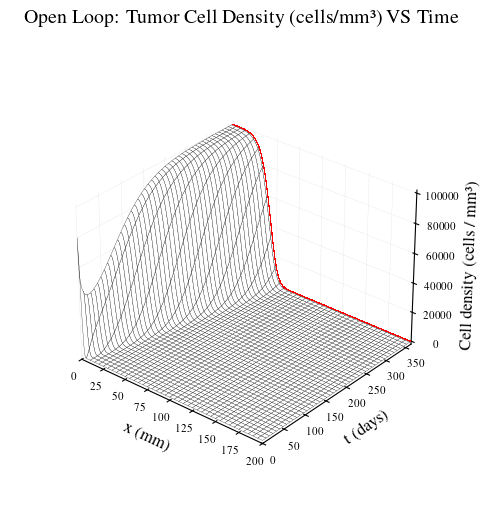

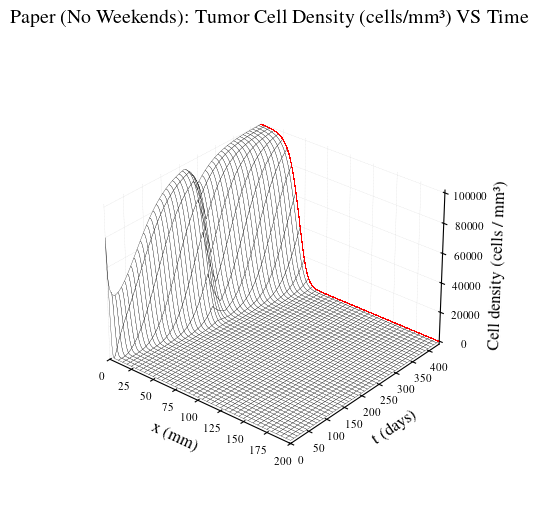

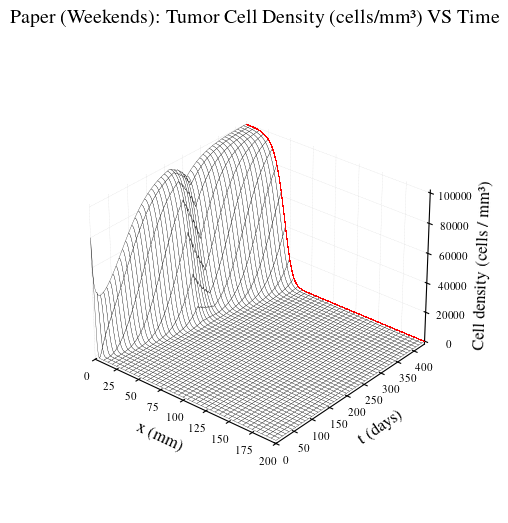

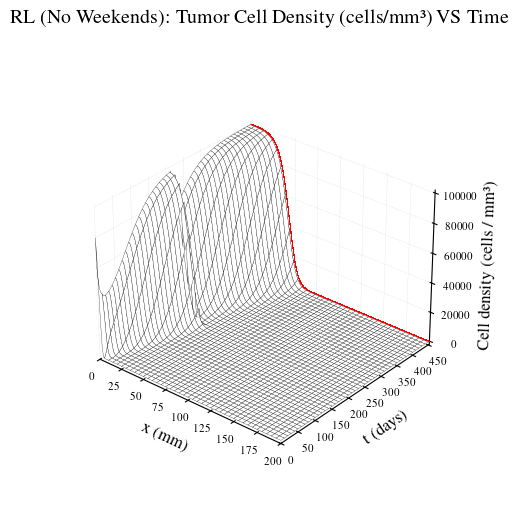

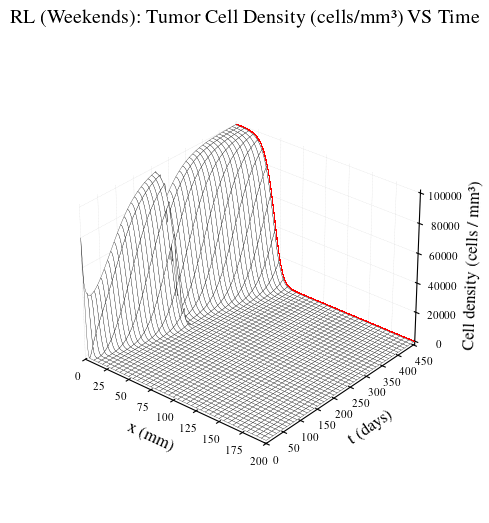

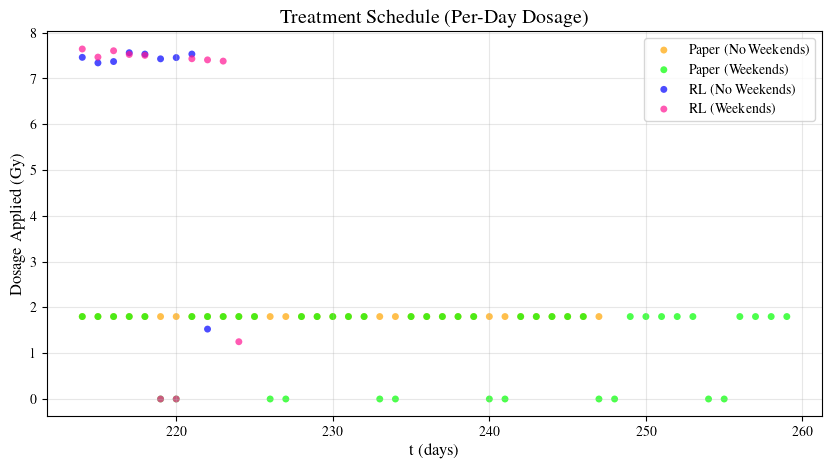

In [ ]:
# Graphs
with suppress_output():
    rew_open_loop, u_open_loop = runSingleEpisode(openLoopController, env_ol_wrapped, None)
    open_loop_treatments = env_ol_base.unwrapped.dosage_vs_time
    plot3D(env_ol_base, "Open Loop")

    rew_paper_no_weekends, u_paper_no_weekends = runSingleEpisode(makePaperController(paper_proportions), env_paper_wrapped_no_weekends, None)
    paper_no_weekend_treatments = env_paper_wrapped_no_weekends.unwrapped.dosage_vs_time
    plot3D(env_paper_base, "Paper (No Weekends)")

    rew_paper_weekends, u_paper_weekends = runSingleEpisode(makePaperController(paper_proportions), env_paper_wrapped_weekends, None)
    paper_weekend_treatments = env_paper_wrapped_weekends.unwrapped.dosage_vs_time
    plot3D(env_paper_base, "Paper (Weekends)")

    rew_rl_no_weekends, u_rl_no_weekends = runSingleEpisode(RLController, env_rl_wrapped_no_weekends, ppo_model)
    rl_no_weekend_treatments = env_rl_wrapped_no_weekends.unwrapped.dosage_vs_time
    plot3D(env_rl_base, "RL (No Weekends)")

    rew_rl_weekends, u_rl_weekends = runSingleEpisode(RLController, env_rl_wrapped_weekends, ppo_model)
    rl_weekend_treatments = env_rl_wrapped_weekends.unwrapped.dosage_vs_time
    plot3D(env_rl_base, "RL (Weekends)")

def clip_first_last_zeros(arr):
    nonzero_indices = np.nonzero(arr)[0]
    if len(nonzero_indices) == 0:
        return np.array([]), np.array([])
    start, end = nonzero_indices[0], nonzero_indices[-1]
    x = np.arange(start, end + 1)
    y = arr[start:end + 1]
    return x, y

days = np.arange(len(open_loop_treatments))
colors = {
    "open_loop": "#000000",
    "paper_no_weekend": "#ffa500",
    "paper_weekend": "#00ff00",
    "rl_no_weekend": "#0000ff",
    "rl_weekend": "#ff1493"        
}

plt.figure(figsize=(10, 5))
for label, arr, color in [
    ("Paper (No Weekends)", paper_no_weekend_treatments, colors["paper_no_weekend"]),
    ("Paper (Weekends)", paper_weekend_treatments, colors["paper_weekend"]),
    ("RL (No Weekends)", rl_no_weekend_treatments, colors["rl_no_weekend"]),
    ("RL (Weekends)", rl_weekend_treatments, colors["rl_weekend"]),
]:
    x, y = clip_first_last_zeros(arr)
    plt.scatter(x, y, color=color, s=25, label=label, alpha=0.7, edgecolors="none")

plt.xlabel("t (days)")
plt.ylabel("Dosage Applied (Gy)")
plt.title("Treatment Schedule (Per-Day Dosage)")
plt.legend()
plt.grid(True, alpha=0.3)

plt.show()